In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/ml_scale/recommender_system

/content/drive/MyDrive/ml_scale/recommender_system


In [ ]:
# @title import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time
from datetime import datetime
import sys, os
import pickle

In [ ]:
sys.path.append('/content/drive/MyDrive/recommender_system/src')


In [ ]:
# @title Load data
from src.data_struct.split_train_test import split_train_test, split_train_test_temporal_ratio
from src.training.features_function import extract_features, create_feature_matrix


def load_and_split_data(ratings_file='data/ml-32m/ratings.csv',
                        movies_file='data/ml-32m/movies.csv',
                        test_ratio=0.2,
                        random_state=42):
    """
    Load data and split into train/test : 80% for train and 20% for test

    """

    # Split data
    (userid_to_idx, idx_to_userid, data_train_by_user, data_test_by_user,
     movieid_to_idx, idx_to_movieid, data_train_by_movie, data_test_by_movie) = \
        split_train_test(ratings_file, 1 - test_ratio)

    # Load movies dataframe for recommendations
    movies_df = pd.read_csv(movies_file)

    # Extract features
    feature_to_idx, idx_to_feature, movie_features, feature_movies = \
        extract_features(movies_file, movieid_to_idx)

    num_movies = len(movieid_to_idx)
    num_features = len(idx_to_feature)
    F, F_n = create_feature_matrix(movie_features, num_movies, num_features)

    print(f"Data loaded:")
    print(f"  Users: {len(userid_to_idx)}")
    print(f"  Movies: {num_movies}")
    print(f"  Features: {num_features}")
    print(f"  Train: {sum(len(r) for r in data_train_by_user)} ratings")
    print(f"  Test: {sum(len(r) for r in data_test_by_user)} ratings\n")

    return {
        'userid_to_idx': userid_to_idx,
        'idx_to_userid': idx_to_userid,
        'movieid_to_idx': movieid_to_idx,
        'idx_to_movieid': idx_to_movieid,
        'data_train_by_user': data_train_by_user,
        'data_train_by_movie': data_train_by_movie,
        'data_test_by_user': data_test_by_user,
        'data_test_by_movie': data_test_by_movie,
        'movies_df': movies_df,
        'F': F,
        'F_n': F_n,
        'feature_to_idx': feature_to_idx,
        'idx_to_feature': idx_to_feature,
        'movie_features': movie_features
    }

# Load data once
data = load_and_split_data()

Data loaded:
  Users: 200948
  Movies: 84432
  Features: 19
  Train: 25603187 ratings
  Test: 6397017 ratings



In [ ]:

# @title Train bias only
from src.training.train_bias_only import train_numba as train_bias
N = 50  # Number of iterations

lamda_bias = 0.01
gamma_bias = 0.01

results_bias = train_bias(
    data['data_train_by_user'],
    data['data_train_by_movie'],
    data['data_test_by_user'],
    lamda_bias, gamma_bias, N
)





Training Bias Only Model...
  lamda=0.01, gamma=0.01, N=50
  Iter   1/50: Train RMSE=0.8606, Test RMSE=0.8701
  Iter   5/50: Train RMSE=0.8468, Test RMSE=0.8563
  Iter  10/50: Train RMSE=0.8467, Test RMSE=0.8562
  Iter  15/50: Train RMSE=0.8466, Test RMSE=0.8561
  Iter  20/50: Train RMSE=0.8466, Test RMSE=0.8561
  Iter  25/50: Train RMSE=0.8466, Test RMSE=0.8560
  Iter  30/50: Train RMSE=0.8465, Test RMSE=0.8560
  Iter  35/50: Train RMSE=0.8465, Test RMSE=0.8560
  Iter  40/50: Train RMSE=0.8465, Test RMSE=0.8560
  Iter  45/50: Train RMSE=0.8465, Test RMSE=0.8561
  Iter  50/50: Train RMSE=0.8465, Test RMSE=0.8561
  Completed in 23.53s
  Final Train RMSE: 0.8465
  Final Test RMSE: 0.8561



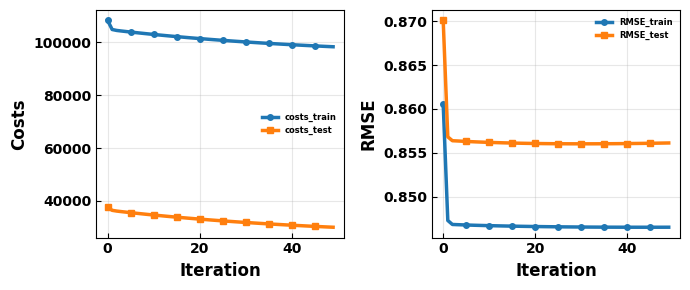

In [ ]:
from src.visualization.plot_loss_rmse import plot

plot(results_bias['costs_train'], results_bias['costs_test'],
     results_bias['rmse_train'], results_bias['rmse_test'])

In [ ]:
# @title Train for bias + Embedding

from src.training.train_parallelize import train as train_bias_embedding
N = 50  # Number of iterations

k = 10
lamda_emb = 0.1
gamma_emb = 0.05
tau_emb = 1.0

results_embedding = train_bias_embedding(
    data['data_train_by_user'],
    data['data_train_by_movie'],
    data['data_test_by_user'],
    k, lamda_emb, gamma_emb, tau_emb, N
)



 k=10
lamda=0.1, gamma=0.05, tau=1.0



KeyboardInterrupt: 

In [ ]:
plot(results_embedding['costs_train'], results_embedding['costs_test'],
     results_embedding['rmse_train'], results_embedding['rmse_test'])

In [ ]:
# @title train feature + bias +  embedding

from src.training.train_with_features import train_with_features
N = 50  # Number of iterations

k = 10
lamda_feat = 0.1
gamma_feat = 0.01
tau_feat = 1.0

results_features = train_with_features(
    data['data_train_by_user'],
    data['data_train_by_movie'],
    data['data_test_by_user'],
    data['F'], data['F_n'],
    k, lamda_feat, gamma_feat, tau_feat, N
)

plot(results_features['costs_train'], results_features['costs_test'],
     results_features['rmse_train'], results_features['rmse_test'])


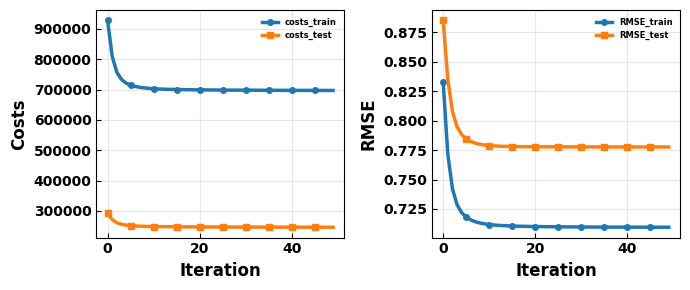

In [ ]:

plot(results_features['costs_train'], results_features['costs_test'],
     results_features['rmse_train'], results_features['rmse_test'])

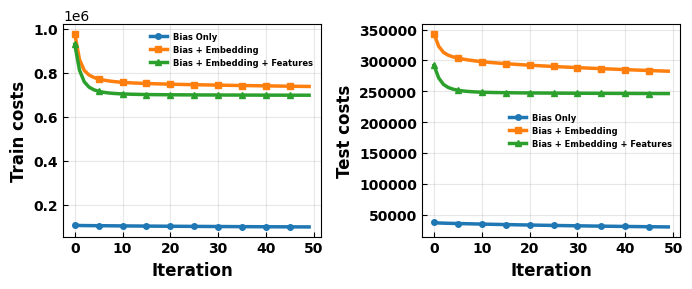

In [ ]:
from src.visualization.plot_compare import plot_compare_costs, plot_compare_rmse

plot_compare_costs(results_bias, results_embedding, results_features)

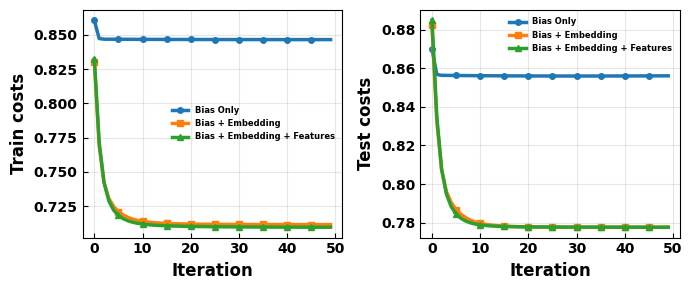

In [ ]:
plot_compare_rmse(results_bias, results_embedding, results_features)


In [ ]:
# @title re-train on full datasets

from src.data_struct.split_train_test import split_train_test, split_train_test_temporal_ratio
from src.training.features_function import extract_features, create_feature_matrix

# Load data for retrain on full dataset
data = load_and_split_data(test_ratio = 0.0)

Data loaded:
  Users: 200948
  Movies: 84432
  Features: 19
  Train: 32000204 ratings
  Test: 0 ratings



In [ ]:

N = 50
k = 10
lamda_emb = 0.1
gamma_emb = 0.05
tau_emb = 1.0

results_embedding = train_bias_embedding(
    data['data_train_by_user'],
    data['data_train_by_movie'],
    data['data_test_by_user'],
    k, lamda_emb, gamma_emb, tau_emb, N
)



 k=10
lamda=0.1, gamma=0.05, tau=1.0

Iteration   1/50	Train Loss: 1204778.1659	Train RMSE: 0.8335	Test Loss:     0.0000	Test RMSE: 0.0000	Time: 107.12s
Iteration   5/50	Train Loss: 949580.4921	Train RMSE: 0.7252	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  53.11s
Iteration  10/50	Train Loss: 931966.0363	Train RMSE: 0.7183	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  63.54s
Iteration  15/50	Train Loss: 926836.9553	Train RMSE: 0.7171	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  61.75s
Iteration  20/50	Train Loss: 923932.1221	Train RMSE: 0.7167	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  60.68s
Iteration  25/50	Train Loss: 921740.4143	Train RMSE: 0.7165	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  60.66s
Iteration  30/50	Train Loss: 919886.3064	Train RMSE: 0.7164	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  60.94s
Iteration  35/50	Train Loss: 918233.5202	Train RMSE: 0.7163	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  60.90s
Iteration  40/50	Train Loss: 916720.4059	Train RM

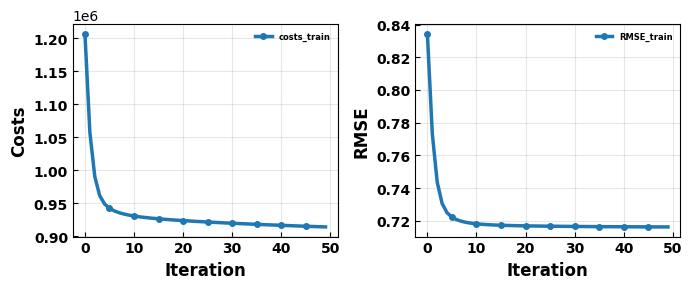

In [ ]:
plot(results_embedding['costs_train'], results_embedding['costs_test'],
     results_embedding['rmse_train'], results_embedding['rmse_test'])

In [ ]:
# @title retrain feature + bias +  embedding

# Model 3: Bias + Embedding + Features
from train_with_features import train_with_features
k = 10
lamda_feat = 0.1
gamma_feat = 0.01
tau_feat = 1.0

results_features = train_with_features(
    data['data_train_by_user'],
    data['data_train_by_movie'],
    data['data_test_by_user'],
    data['F'], data['F_n'],
    k, lamda_feat, gamma_feat, tau_feat, N
)

plot(results_features['costs_train'], results_features['costs_test'],
     results_features['rmse_train'], results_features['rmse_test'])


Training with features:
  k=10, lamda=0.1, gamma=0.01, tau=1.0
  Users: 200948, Movies: 84432, Features: 19

Iter   1/50	Train Loss: 1154074.1025	Train RMSE: 0.8347	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  49.85s
Iter   5/50	Train Loss: 899767.8275	Train RMSE: 0.7269	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  63.46s
Iter  10/50	Train Loss: 878512.6899	Train RMSE: 0.7180	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  80.65s
Iter  15/50	Train Loss: 873219.1300	Train RMSE: 0.7162	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  81.80s
Iter  20/50	Train Loss: 870787.7699	Train RMSE: 0.7155	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  78.20s
Iter  25/50	Train Loss: 869360.3542	Train RMSE: 0.7152	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  82.61s
Iter  30/50	Train Loss: 868415.8332	Train RMSE: 0.7150	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  81.46s
Iter  35/50	Train Loss: 867742.5778	Train RMSE: 0.7149	Test Loss:     0.0000	Test RMSE: 0.0000	Time:  78.70s
Iter  40/50	Train 

NameError: name 'plot' is not defined

In [ ]:
# @title Save results for bias + feature
# import pickle

# with open("results_bias_embedding_full_dataset.pkl", "wb") as f:
#     pickle.dump(results_embedding, f)

In [ ]:
# with open("results_bias_embedding_full_dataset.pkl", "rb") as f:
#     results_embedding = pickle.load(f)

In [ ]:
# with open("results_features_full_dataset.pkl", "wb") as f:
#     pickle.dump(results_features, f)

In [ ]:
# with open("results_features_full_dataset.pkl", "rb") as f:
#     results_features = pickle.load(f)

In [ ]:
# @title t-sne

from sklearn.manifold import TSNE

from matplotlib.lines import Line2D





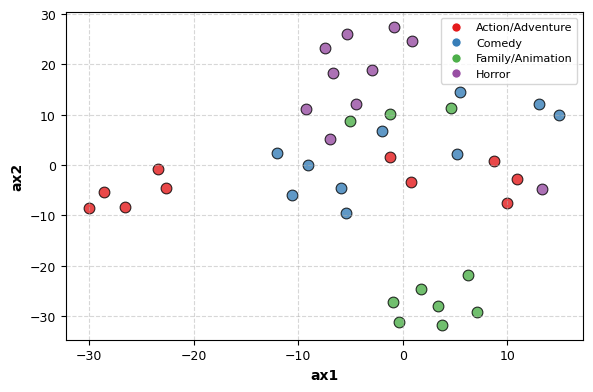

In [ ]:

selected_movies = {
    'Action/Adventure': ['Lord of the Rings, The (1978)', 'Lord of the Rings: The Fellowship of',
                         'Lord of the Rings: The Two Towers', 'Lord of the Rings: The Return of the King'],
    'Family/Animation': ['Toy Story', 'Toy Story 2', 'Toy Story 3'],
    'Comedy': ['Home Alone', 'Home Alone 2', 'Home Alone 3'],
    'Horror': ['Halloween', 'Friday the 13th', 'Alien']
}

def find_movie_idx(title_part, movies_df, movieid_to_idx):
    """Find movie index by partial title match"""
    matches = movies_df[movies_df['title'].str.contains(title_part, case=False, na=False, regex=False)]
    if len(matches) > 0:
        movie_id = str(matches.iloc[0]['movieId'])
        if movie_id in movieid_to_idx:
            return movieid_to_idx[movie_id], matches.iloc[0]['title']
    return None, None

movie_indices = {}
movie_titles_full = {}
for genre, titles in selected_movies.items():
    for title in titles:
        idx, full_title = find_movie_idx(title, data['movies_df'], data['movieid_to_idx'])
        if idx is not None:
            movie_indices.setdefault(genre, []).append(idx)
            movie_titles_full.setdefault(genre, []).append(full_title)

v_emb = results_embedding['v']
selected_indices = [idx for indices in movie_indices.values() for idx in indices]
v_selected = v_emb[selected_indices]

tsne = TSNE(n_components=2, random_state=100, perplexity=10, max_iter=1000)
v_selected_2d = tsne.fit_transform(v_selected)

tsne_coords = dict(zip(selected_indices, v_selected_2d))

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 9})

colors = {
    'Action/Adventure': 'red',
    'Comedy': 'blue',
    'Family/Animation': 'green',
    'Horror': 'purple'
}

for genre, indices in movie_indices.items():
    for i, idx in enumerate(indices):
        x, y = tsne_coords[idx]
        plt.scatter(x, y, c=colors[genre], s=60, alpha=0.8,
                    edgecolors='black', linewidth=0.8)
        plt.annotate(movie_titles_full[genre][i][:15] + '...',
                     (x, y), fontsize=7, fontweight='bold', alpha=0.9,
                     xytext=(4, 4), textcoords='offset points')

plt.xlabel('ax1', fontsize=10, fontweight='bold')
plt.ylabel('ax2', fontsize=10, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)


legend_elements = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=colors[g], markersize=7, label=g)
                   for g in colors]
plt.legend(handles=legend_elements, fontsize=8, loc='best', frameon=True)
plt.tight_layout()
plt.show()


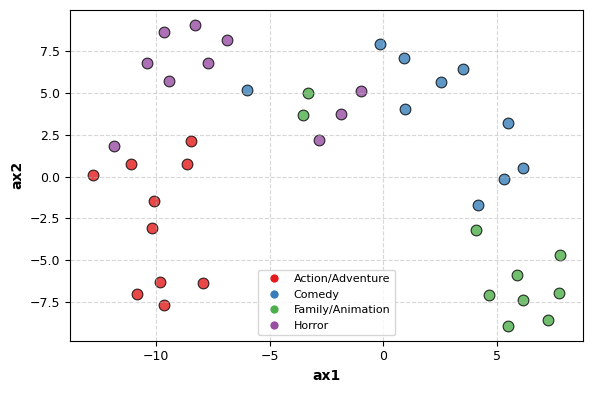

In [ ]:
#  @title movie embedding for features model


movie_indices = {}
movie_titles_full = {}
for genre, titles in selected_movies.items():
    for title in titles:
        idx, full_title = find_movie_idx(title, data['movies_df'], data['movieid_to_idx'])
        if idx is not None:
            movie_indices.setdefault(genre, []).append(idx)
            movie_titles_full.setdefault(genre, []).append(full_title)

v_feat = results_features['v']
selected_indices = [idx for indices in movie_indices.values() for idx in indices]
v_selected = v_feat[selected_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=3, max_iter=1000)
v_selected_2d = tsne.fit_transform(v_selected)

tsne_coords = dict(zip(selected_indices, v_selected_2d))

plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 9})

colors = {
    'Action/Adventure': 'red',
    'Comedy': 'blue',
    'Family/Animation': 'green',
    'Horror': 'purple'
}

for genre, indices in movie_indices.items():
    for i, idx in enumerate(indices):
        x, y = tsne_coords[idx]
        plt.scatter(x, y, c=colors[genre], s=60, alpha=0.8,
                    edgecolors='black', linewidth=0.8)
        plt.annotate(movie_titles_full[genre][i][:15] + '...',
                     (x, y), fontsize=7, fontweight='bold', alpha=0.9,
                     xytext=(4, 4), textcoords='offset points')

plt.xlabel('ax1', fontsize=10, fontweight='bold')
plt.ylabel('ax2', fontsize=10, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

legend_elements = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=colors[g], markersize=7, label=g)
                   for g in colors]
plt.legend(handles=legend_elements, fontsize=8, loc='best', frameon=True)
plt.tight_layout()
plt.show()


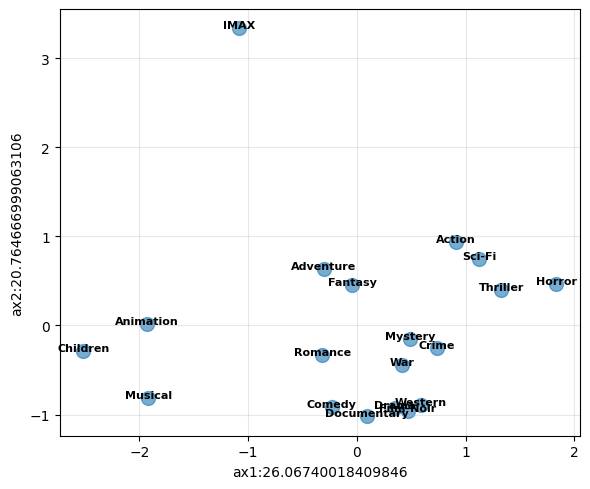

In [ ]:
# @title features embedding
from sklearn.decomposition import PCA


feature_vectors = results_features['f_vectors']
feature_name = [f_name for f_name in data['feature_to_idx'].keys()]

pca = PCA(n_components=2)
features_2d = pca.fit_transform(feature_vectors)
ratios = pca.explained_variance_ratio_

pc1 = ratios[0] * 100
pc2 = ratios[1] * 100

plt.figure(figsize=(6, 5))
plt.scatter(features_2d[:, 0], features_2d[:, 1], s=100, alpha=0.6)

for i, name in enumerate(feature_name):
    plt.annotate(name, (features_2d[i, 0], features_2d[i, 1]),
                fontsize=8, fontweight='bold',ha='center')

plt.xlabel(f'ax1:{pc1}', fontsize=10)
plt.ylabel(f'ax2:{pc2}', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
#plt.savefig('genre_embeddings.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# @title polarizing

def find_polarizing_movies(movies_df, v_emb, b_movie, data_train_by_movie,
                          idx_to_movieid, movies_file='data/ml-32m/movies.csv',
                          min_ratings=500, top_k=20):
    """
    Args:
        v_emb: Movie embeddings (num_movies, K)
        b_movie: Movie biases (num_movies,)
        data_train_by_movie: List of ratings per movie
        idx_to_movieid: Mapping from index to movie ID
        movies_file: Path to movies.csv
        min_ratings: Minimum number of ratings required
        top_k: Number of top polarizing movies to return

    Returns:
        DataFrame with polarizing movies
    """

    # Calculate number of ratings per movie
    num_ratings = np.array([len(ratings) for ratings in data_train_by_movie])

    # Calculate L2 norm of each movie embedding
    v_norms = np.linalg.norm(v_emb, axis=1)

    # Filter movies with enough ratings
    valid_mask = num_ratings >= min_ratings

    # Create results array
    results = []
    for movie_idx in range(len(v_emb)):
        if valid_mask[movie_idx]:
            movie_id = idx_to_movieid[movie_idx]
            movie_title = movies_df[movies_df['movieId'] == int(movie_id)]['title'].values

            if len(movie_title) > 0:
                results.append({
                    'movie_idx': movie_idx,
                    'movie_id': movie_id,
                    'title': movie_title[0],
                    'v_norm': v_norms[movie_idx],
                    'bias': b_movie[movie_idx],
                    'abs_bias': abs(b_movie[movie_idx]),
                    'num_ratings': num_ratings[movie_idx]
                })

    # Convert to DataFrame
    df = pd.DataFrame(results)

    df = df.sort_values(['v_norm', 'abs_bias'], ascending=[False, True])

    return df.head(top_k)



In [ ]:
results_embedding.keys()

dict_keys(['user_biases', 'movie_biases', 'u', 'v', 'rmse_train', 'rmse_test', 'costs_train', 'costs_test', 'duration'])

In [ ]:

# Find polarizing movies
print("Finding polarizing movies...")


polarizing_df = find_polarizing_movies(
    data['movies_df'],
    v_emb=results_embedding['v'],
    b_movie=results_embedding['movie_biases'],
    data_train_by_movie=data['data_train_by_movie'],
    idx_to_movieid=data['idx_to_movieid'],
    min_ratings=500,
    top_k=20
)

print("\nTop 20 Most Polarizing Movies:")
print("(High embedding norm + Low bias + Many ratings)")
print("-"*80)
print(f"{'Rank':<5} {'Title':<50} {'||v||':<8} {'Bias':<8} {'#Ratings':<10}")
print("-"*80)

for i, row in polarizing_df.iterrows():
    print(f"{i+1:<5} {row['title'][:48]:<50} {row['v_norm']:<8.3f} {row['bias']:<8.3f} {row['num_ratings']:<10.0f}")

print(f"Average v_norm (all movies): {np.mean(np.linalg.norm(results_embedding['v'], axis=1)):.3f}")
print(f"Average v_norm (polarizing): {polarizing_df['v_norm'].mean():.3f}")
print(f"Average bias (all movies):   {np.mean(np.abs(results_embedding['movie_biases'])):.3f}")
print(f"Average bias (polarizing):   {polarizing_df['abs_bias'].mean():.3f}")

Finding polarizing movies...

Top 20 Most Polarizing Movies:
(High embedding norm + Low bias + Many ratings)
--------------------------------------------------------------------------------
Rank  Title                                              ||v||    Bias     #Ratings  
--------------------------------------------------------------------------------
152   Dumb & Dumber (Dumb and Dumber) (1994)             7.158    -0.490   36802     
610   Lord of the Rings: The Return of the King, The (   6.918    0.574    67449     
593   Lord of the Rings: The Two Towers, The (2002)      6.836    0.548    67463     
336   Lord of the Rings: The Fellowship of the Ring, T   6.802    0.590    73122     
580   Star Wars: Episode II - Attack of the Clones (20   6.685    -0.270   27415     
329   Star Wars: Episode I - The Phantom Menace (1999)   6.492    -0.273   37973     
650   Star Wars: Episode III - Revenge of the Sith (20   6.472    0.007    24773     
162   Ace Ventura: Pet Detective (1994)  

In [ ]:

# Find polarizing movies
print("Finding polarizing movies...")


polarizing_features = find_polarizing_movies(
    data['movies_df'],
    v_emb=results_features['v'],
    b_movie=results_features['movie_biases'],
    data_train_by_movie=data['data_train_by_movie'],
    idx_to_movieid=data['idx_to_movieid'],
    min_ratings=500,
    top_k=20
)

print("\nTop 20 Most Polarizing Movies:")
print("(High embedding norm + Low bias + Many ratings)")
print("-"*80)
print(f"{'Rank':<5} {'Title':<50} {'||v||':<8} {'Bias':<8} {'#Ratings':<10}")
print("-"*80)

for i, row in polarizing_features.iterrows():
    print(f"{i+1:<5} {row['title'][:48]:<50} {row['v_norm']:<8.3f} {row['bias']:<8.3f} {row['num_ratings']:<10.0f}")

# Additional analysis: Show distribution



print(f"Average v_norm (all movies): {np.mean(np.linalg.norm(results_features['v'], axis=1)):.3f}")
print(f"Average v_norm (polarizing): {polarizing_features['v_norm'].mean():.3f}")
print(f"Average bias (all movies):   {np.mean(np.abs(results_features['movie_biases'])):.3f}")
print(f"Average bias (polarizing):   {polarizing_features['abs_bias'].mean():.3f}")

Finding polarizing movies...

Top 20 Most Polarizing Movies:
(High embedding norm + Low bias + Many ratings)
--------------------------------------------------------------------------------
Rank  Title                                              ||v||    Bias     #Ratings  
--------------------------------------------------------------------------------
610   Lord of the Rings: The Return of the King, The (   7.748    0.430    67449     
593   Lord of the Rings: The Two Towers, The (2002)      7.654    0.402    67463     
336   Lord of the Rings: The Fellowship of the Ring, T   7.637    0.440    73122     
152   Dumb & Dumber (Dumb and Dumber) (1994)             7.612    -0.558   36802     
1322  Avengers: Infinity War - Part II (2019)            7.002    0.399    11811     
1389  Harry Potter and the Deathly Hallows: Part 1 (20   6.978    0.153    20969     
1388  Harry Potter and the Half-Blood Prince (2009)      6.930    0.116    21033     
2839  Avengers: Infinity War - Part I (20

In [ ]:
def find_polarizing_movies_improved(movies_df,  v_emb, b_movie,
                                    data_train_by_movie, idx_to_movieid,
                                   min_ratings=500, top_k=20):
    results = []
    for movie_idx in range(len(v_emb)):
        ratings_list = data_train_by_movie[movie_idx]

        if len(ratings_list) < min_ratings:
            continue

        ratings = [r for _, r in ratings_list]
        mean_rating = np.mean(ratings)
        std_rating = np.std(ratings)

        movie_id = idx_to_movieid[movie_idx]
        movie_title = movies_df[movies_df['movieId'] == int(movie_id)]['title'].values

        if len(movie_title) > 0:
            v_norm = np.linalg.norm(v_emb[movie_idx])
            bias = b_movie[movie_idx]

            results.append({
                'movie_idx': movie_idx,
                'title': movie_title[0],
                'v_norm': v_norm,
                'bias': bias,
                'abs_bias': abs(bias),
                'mean': mean_rating,
                'std': std_rating,
                'num_ratings': len(ratings)
            })

    df = pd.DataFrame(results)

    polarizing = df[(df['std'] > 1.15)]
    polarizing = polarizing.sort_values('v_norm', ascending=False)

    return polarizing.head(top_k)

In [ ]:
data['movies_df'].columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [ ]:

# Find polarizing movies
print("Finding polarizing movies...")


polarizing_features_improved = find_polarizing_movies_improved(
    data['movies_df'],
    v_emb=results_features['v'],
    b_movie=results_features['movie_biases'],
    data_train_by_movie=data['data_train_by_movie'],
    idx_to_movieid=data['idx_to_movieid'],
    min_ratings=500,
    top_k=20
)

print("\nTop 20 Most Polarizing Movies:")
print("(High embedding norm + Low bias + Many ratings)")
print("-"*80)
print(f"{'Rank':<5} {'Title':<50} {'||v||':<8} {'Bias':<8} {'#Ratings':<10}")
print("-"*80)

for i, row in polarizing_features_improved.iterrows():
    print(f"{i+1:<5} {row['title'][:48]:<50} {row['v_norm']:<8.3f} {row['bias']:<8.3f} {row['num_ratings']:<10.0f}")

# Additional analysis: Show distribution

print("")
print("\n STATISTICS")

print(f"Average v_norm (all movies): {np.mean(np.linalg.norm(results_features['v'], axis=1)):.3f}")
print(f"Average v_norm (polarizing): {polarizing_features_improved['v_norm'].mean():.3f}")
print(f"Average bias (all movies):   {np.mean(np.abs(results_features['movie_biases'])):.3f}")
print(f"Average bias (polarizing):   {polarizing_features_improved['abs_bias'].mean():.3f}")

Finding polarizing movies...

Top 20 Most Polarizing Movies:
(High embedding norm + Low bias + Many ratings)
--------------------------------------------------------------------------------
Rank  Title                                              ||v||    Bias     #Ratings  
--------------------------------------------------------------------------------
152   Dumb & Dumber (Dumb and Dumber) (1994)             7.612    -0.558   36802     
341   Ace Ventura: When Nature Calls (1995)              6.676    -0.852   24849     
306   Blair Witch Project, The (1999)                    6.390    -0.667   22780     
4320  Twilight Saga: Eclipse, The (2010)                 6.302    -1.076   4060      
1001  Twilight (2008)                                    6.230    -0.944   8882      
405   Saw (2004)                                         6.212    -0.343   12829     
4731  Twilight Saga: Breaking Dawn - Part 2, The (2012   6.202    -0.966   2362      
321   Natural Born Killers (1994)        

In [ ]:
# @title recommendation

res = data['movies_df'][data['movies_df']['title'].str.contains("Lord of the Rings", case=False, na=False)]
display(res)


,movieId,title,genres
2026,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
4888,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5841,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7029,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
71797,231829,A Passage to Middle-earth: Making of 'Lord of ...,Documentary
79743,267392,"J.R.R. Tolkien and the Birth Of ""The Lord of t...",(no genres listed)


In [ ]:
list_id = [data['movieid_to_idx'][str(e)] for e in res['movieId'].values]
print(list_id)

[1819, 339, 596, 613, 46075, 67934]


In [ ]:
from src.prediction.recommendation import get_user_recommendations_embedding
k = 10
lamda_feat = 0.1
gamma_feat = 0.01
tau_feat = 1.0

dummy_data = [(1819, 5.0)]
movie_idx_rated = [x[0] for x in dummy_data]

recomm = get_user_recommendations_embedding(dummy_data, results_features['movie_biases'],
                                  results_features['v'], data['idx_to_movieid'],
                                  data['movies_df'], k, lamda_feat, gamma_feat,
                                  tau_feat, top_k=10, bias_weight=1)
lord_ring_recommendation = pd.DataFrame(recomm)
lord_ring_recommendation

,movie_idx,movie_id,title,genres,score
0,80343,291314,Young Pioneers (1976),Western,4.634388
1,44824,216789,Destination: Pluto Beyond the Flyby (2016),Documentary,3.719821
2,70093,225435,Wesley (2009),(no genres listed),3.516445
3,80262,291112,A Mother's Gift (1995),Drama|Western,3.185678
4,70088,225425,Pilgrim's Progress - Journey To Heaven (2008),(no genres listed),3.064273
5,70094,225437,Crazy Bible (2018),(no genres listed),3.064273
6,80067,246906,Hero Dog: The Journey Home (2021),Adventure,2.977032
7,80089,253946,48 Below (2012),Adventure,2.977032
8,80365,291981,Abducted by My Teacher: The Elizabeth Thomas S...,Crime|Thriller,2.952974
9,29497,270306,WWE: The Triumph and Tragedy of World Class Ch...,Action|Documentary,2.919927


In [ ]:
# @title save recommendation
def save_recommendation(movie_recommendation, path):
  table_recommendation = movie_recommendation[["title","score"]].to_latex(index=False, float_format="%.3f")
  with open(path, "w") as f:
     f.write(table_recommendation)

In [ ]:
from src.prediction.recommendation import get_user_recommendations_embedding
k = 10
lamda_feat = 0.1
gamma_feat = 0.01
tau_feat = 1.0

dummy_data = [(1819, 5.0)]
movie_idx_rated = [x[0] for x in dummy_data]

recomm = get_user_recommendations_embedding(dummy_data, results_features['movie_biases'],
                                  results_features['v'], data['idx_to_movieid'],
                                  data['movies_df'], k, lamda_feat, gamma_feat,
                                  tau_feat, top_k=10, bias_weight=0.05)
lord_ring_recommendation = pd.DataFrame(recomm)
lord_ring_recommendation

,movie_idx,movie_id,title,genres,score
0,613,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,1.248706
1,596,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,1.232061
2,339,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,1.218760
3,655,33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi,1.051546
4,583,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,1.048880
5,902,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX,1.006379
6,888,98809,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX,0.990169
7,1152,118696,The Hobbit: The Battle of the Five Armies (2014),Adventure|Fantasy,0.985410
8,332,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,0.985036
9,1439,69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX,0.974181


In [ ]:
from recommendation import get_user_recommendations_embedding
k = 10
lamda_emb = 0.1
gamma_emb = 0.05
tau_emb = 1.0

dummy_data = [(1819, 5.0)]
movie_idx_rated = [x[0] for x in dummy_data]

recomm = get_user_recommendations_embedding(dummy_data, results_embedding['movie_biases'],
                                  results_embedding['v'], data['idx_to_movieid'],
                                  data['movies_df'], k, lamda_emb, gamma_emb,
                                  tau_emb, top_k=10, bias_weight=0.05,model="without_features")
lord_ring_recommendation = pd.DataFrame(recomm)
lord_ring_recommendation

,movie_idx,movie_id,title,genres,score
0,583,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,2.493659
1,655,33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi,2.439084
2,332,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,2.409048
3,613,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,2.396348
4,596,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,2.372015
5,339,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,2.339288
6,60,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,2.255403
7,15,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,2.122357
8,53,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,2.032151
9,1819,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy,1.952515
